<a href="https://colab.research.google.com/github/jonatanbarkan/ACEDeep/blob/master/ADCEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1345]:
import numpy as np
from scipy.spatial.transform import Rotation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
import tqdm
import pandas as pd
import matplotlib as mpl
from collections import defaultdict
from time import sleep

sns.set_style("whitegrid")
# mpl.rcParams['figure.figsize'] = [12., 8.0]


In [1346]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Create Samples

In [1347]:
d = 3
num_samples = 10000

In [1348]:
mu = [0]*d
cov = np.eye(d)

In [1349]:
kind = 'hex'
# kind = 'scatter'

In [1350]:
def get_normalization_params(dat, axis=0):
  mu = dat.mean(axis=axis)
  dat -= mu
  std = dat.std(axis=axis)
  # dat /= std
  return mu, std

In [1351]:
def normalize(dat, mu, std):
  dat -= mu
  dat /= std
  return dat

In [1352]:
Z = np.random.multivariate_normal(mu, cov, num_samples)
N1 = np.random.multivariate_normal(mu,  cov, num_samples)
N2 = np.random.multivariate_normal(mu,  cov, num_samples)
N3 = np.random.multivariate_normal(mu,  cov, num_samples)
N4 = np.random.multivariate_normal(mu,  cov, num_samples)

In [1353]:
X_prior = Z + np.array([.5, .1, 1.2]) * N1
Y_prior = Z + np.array([.5, .1, 1.2]) * N2

In [1354]:
# (np.array([.5, .1, 1.2]) * N1).shape

In [1355]:
def draw_correlations(A, B, plot=False, labels=["A", "B"], **kwargs):
  eziz = []
  for j in range(A.shape[-1]):
    cor = np.corrcoef(A[:,j], B[:,j], rowvar=False)[0,1]
    print(cor, end='\t')
    eziz.append(cor)
  temp = pd.DataFrame({
      **{f'{labels[0]}_{j}': A[:, j] for j in range(A.shape[-1])},
      **{f'{labels[1]}_{j}': B[:, j] for j in range(B.shape[-1])}
      })
  if plot:
    g = sns.PairGrid(data=temp,
                     y_vars=[f'{labels[0]}_{j}' for j in range(A.shape[-1])],
                     x_vars=[f'{labels[1]}_{j}' for j in range(B.shape[-1])]
                     )
    g.map(sns.scatterplot)
    g.fig.suptitle(kwargs.get('title', ''))
  sleep(0.1)
  print('')
  return eziz

0.8007245648458264	0.9900756677139243	0.390311709124985	


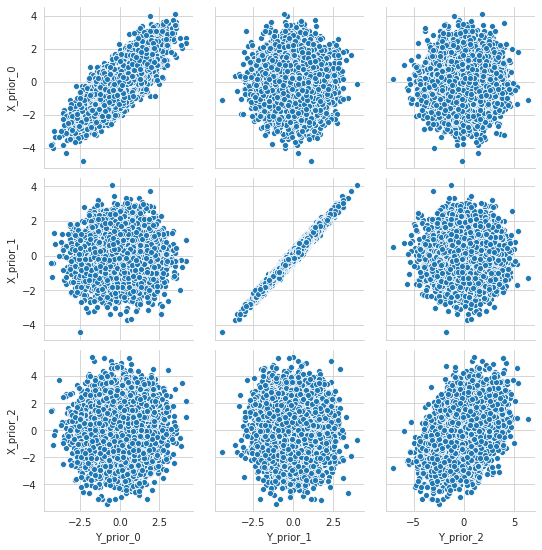

In [1356]:
t = draw_correlations(X_prior, Y_prior, plot=True, labels=['X_prior', 'Y_prior'])

In [1357]:
print('{}')

{}


In [1358]:
add_non_linearity = True

In [1359]:
# torus prametrization
R = 5
def torus(vecs):
  a, b, c = vecs.T
  x1 = (R + c*np.cos(a))*np.cos(b)
  x2 = (R + c*np.cos(a))*np.sin(b)
  x3 = c*np.sin(a)
  return np.vstack((x1, x2, x3)).T


In [1491]:
eps = 0.1
def rational(vecs):
  a, b, c = vecs.T
  x1 = a / (np.abs(b) + eps)
  x2 = b + 20
  x3 = a + 3*c
  return np.vstack((x1, x2, x3)).T


In [1492]:
# non_linearity_1 = lambda a: a
# non_linearity_2 = lambda a: a
# if add_non_linearity:
#   non_linearity_1 = lambda a: np.exp(a) + 2 * a[1]
#   non_linearity_2 = lambda a: np.tan(np.pi * a)
#   # non_linearity_1 = lambda a: np.log(1 + np.abs(a))
#   # non_linearity_2 = lambda a: a + 1/a
  
#   # non_linearity_1 = non_linearity_a

In [1493]:
non_linearity_1 = torus
non_linearity_2 = rational

In [1494]:
X_non_linear = non_linearity_1(X_prior)
Y_non_linear = non_linearity_2(Y_prior)

0.0014105463566681895	0.8882965162796709	-0.012946599640894684	


[0.0014105463566681895, 0.8882965162796709, -0.012946599640894684]

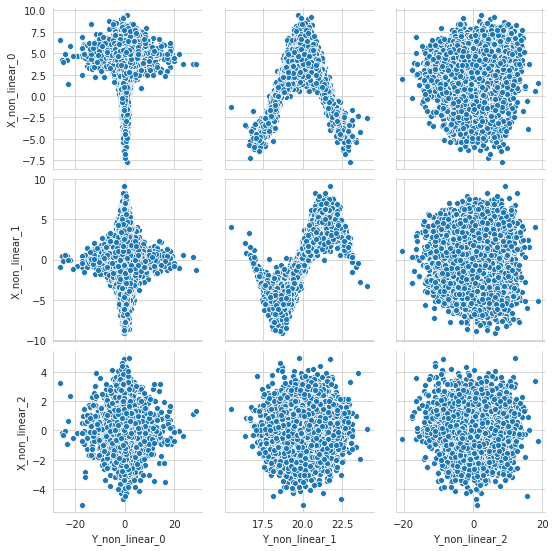

In [1495]:
draw_correlations(X_non_linear, Y_non_linear, True, labels=['X_non_linear', 'Y_non_linear'])

In [1496]:
thetaX = [0] * d
thetaX[2] = np.pi/2
rot_axis_X = np.array([1, 1, 1])
rotX = Rotation.from_rotvec(thetaX * rot_axis_X)
X = rotX.apply(X_non_linear)

In [1497]:
print(f'X: mean {np.mean(X, axis=0)}, std {np.std(X, axis=0)}')

X: mean [9.95775710e-04 3.03791580e+00 1.23209879e-02], std [3.36036667 2.40525911 1.03527393]


In [1498]:
X += np.array([.1, .1, .1]) * N3

In [1499]:
thetaY = [0] * d
thetaY[0] = -np.pi / 2
thetaY[1] = -np.pi / 6
rot_axis_Y = np.array([1, 1, 1])
rotY = Rotation.from_rotvec(thetaY * rot_axis_Y)
Y = rotY.apply(Y_non_linear)

In [1500]:
print(f'X: mean {np.mean(Y, axis=0)}, std {np.std(Y, axis=0)}')

X: mean [  6.52277147   0.49955495 -18.90005299], std [2.90113586 4.82345791 1.36477295]


In [1501]:
Y += np.array([.1, .1, .1]) * N4

$X, Y$ are rotations of a linear combination of $Z + \lambda N1$ and $Z + \lambda N2$ respectively, where $Z, N1, N2$ each drawn from a multivariate gaussian with 0 mean and unit covariance.
$\lambda=0.1$ and the rotations are different and are performed around different axes.

-0.10184057632852336	0.07175224731613	-7.569955440682704e-05	


[-0.10184057632852336, 0.07175224731613, -7.569955440682704e-05]

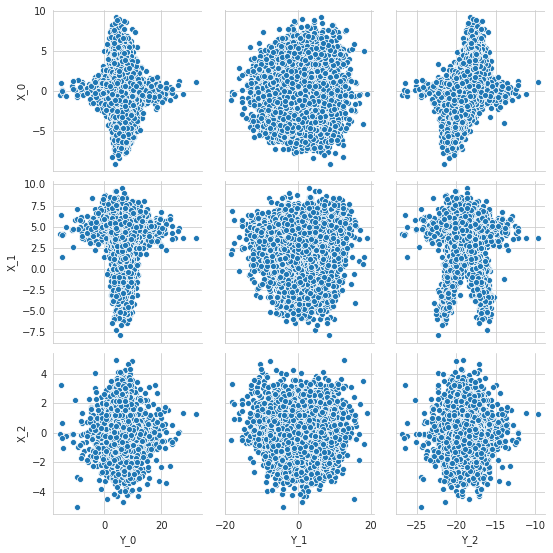

In [1502]:
draw_correlations(X,Y, True, labels=['X', 'Y'])

### create pytorch model class

notice there is no normalization at the final output. Normalization is performed with apply_transform function

In [1503]:
class Model(nn.Module):
  def __init__(self, hidden_size, input_size, output_size, lr=0.01, activation=None):
      super(Model, self).__init__()
      self.fc1 = nn.Linear(input_size, hidden_size)
      # nn.init.xavier_normal_(self.fc1.weight)
      self.bn1 = nn.BatchNorm1d(num_features=hidden_size)
      self.fc2 = nn.Linear(hidden_size, output_size)
      # nn.init.xavier_normal_(self.fc2.weight)
      self.bn2 = nn.BatchNorm1d(num_features=output_size, )
      
      self.learning_rate = lr
      self._criterion = nn.MSELoss()
      self._optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      self.activation = activation
      
  def forward(self, x):
      u = self.fc1(x)
      u = self.bn1(u)
      if self.activation is not None:
        u = self.activation(u)
      u = self.fc2(u)
      u = self.bn2(u)
      return u
    
  def get_criterion(self):
      return self._criterion

  def get_optimizer(self):
      return self._optimizer
  

In [1504]:
class MlpNet(nn.Module):
    def __init__(self, layer_sizes, input_size, lr=0.01, activation=None):
        super(MlpNet, self).__init__()
        if activation is None:
          activation = nn.Identity()
        layers = []
        layer_sizes = [input_size] + layer_sizes
        for l_id in range(len(layer_sizes) - 1):
            if l_id == len(layer_sizes) - 2:
                layers.append(nn.Sequential(
                    nn.BatchNorm1d(num_features=layer_sizes[l_id], affine=False),
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                ))
            else:
                layers.append(nn.Sequential(
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                    activation(),
                    nn.BatchNorm1d(num_features=layer_sizes[l_id + 1], affine=False),
                ))
        
        self.layers = nn.ModuleList(layers)
        self.learning_rate = lr
        self._criterion = nn.MSELoss()
        self._optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def get_criterion(self):
        return self._criterion

    def get_optimizer(self):
        return self._optimizer

In [1505]:
def make_train_step(model):
    # Builds function that performs a step in the train loop
    loss_fn = model.get_criterion()
    optimizer = model.get_optimizer()
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y.detach(), yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [1506]:
def make_eval_step(model):
    # Builds function that performs a step in the train loop
    loss_fn = model.get_criterion()
    def eval_step(x, y):
        # Sets model to TRAIN mode
        model.eval()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return eval_step

### train and eval functions

In [1507]:
def find_orthogonal(M, vec):
  # M an orthogonal matrix, vec the starting vector to be orthogonalized wrt M
  # using (modified?) gram schmidt while assuming M is already orthogonal
  def projection(u, v):
      return ((v * u).sum() / (u * u).sum()) * u
  vec -= torch.sum(torch.cat([projection(M[i, :], vec) for i in range(M.shape[0])], dim=1))
  return vec 

In [1508]:
def apply_initial_guess(inp, method='model', **kwargs):
  if method == 'model':
    return inp
  if method == 'independent':
    pass
  if method == 'mean':
    return (inp.mean() * torch.ones([inp.shape[0], 1])).detach()
  if method == 'zero':
    return torch.zeros([inp.shape[0], 1])
  
  raise NotImplementedError(f'initialization method {method} not implemented')

In [1509]:
def apply_transform(model, inp, first=False, **kwargs):
  model.eval()
  out = model(inp)
  if first:
    out = apply_initial_guess(out, model=model, **kwargs)
  out -= out.mean(axis=0)
  std = out.std(axis=0)
  if not first:
    out = torch.div(out, out.std(axis=0))
  return out

In [1510]:
def learn(loader, _x_model, _y_model, _x_train_step, _y_train_step, inner_loop_iter=3, _max_samples=np.inf, first=False):
  U = []
  V = []
  losses_x = []
  losses_y = []

  sample_count = 0
  inner_loop_count = 0
  x_turn = True
  for x_batch, y_batch in loader:
    inner_loop_count += 1
    sample_count += len(x_batch)
    if sample_count > _max_samples:
      break
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    
    if loop_count % count == 0:
      x_turn = not x_turn
    transformed_y_batch = apply_transform(_y_model, y_batch, first)
    loss_x = _x_train_step(x_batch, transformed_y_batch)
    losses_x.append(loss_x)

    transformed_x_batch = apply_transform(_x_model, x_batch)
    loss_y = _y_train_step(y_batch, transformed_x_batch)
    losses_y.append(loss_y)

    U.append(apply_transform(_y_model, y_batch))
    V.append(transformed_y_batch)

    if first:
      first = False
  U = torch.cat(U)
  V = torch.cat(V)
  # UV = U * V
  # corr = UV.mean(axis=0).item()
  # corr = draw_correlations(U.detach().numpy(), V.detach().numpy(), False)[0]
  corr = np.corrcoef(U.detach().numpy(), V.detach().numpy(), rowvar=False)[0, 1]

  return corr, np.mean(losses_x), np.mean(losses_y)


In [1511]:
def evaluate(loader, _x_model, _y_model, _x_eval_step, _y_eval_step, first=False):
  X = []
  Y = []
  U = []
  V = []
  val_loss_x = []
  val_loss_y = []
  with torch.no_grad(): 
    for x_val, y_val in loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)

      transformed_y_batch = apply_transform(_y_model, y_val, first)
      transformed_x_batch = apply_transform(_x_model, x_val, first)

      X.append(x_val)
      Y.append(y_val)
      U.append(transformed_x_batch)
      V.append(transformed_y_batch)

      val_loss_x.append(_x_eval_step(x_val, transformed_y_batch))
      val_loss_y.append(_y_eval_step(y_val, transformed_x_batch))
  X = torch.cat(X)
  Y = torch.cat(Y)
  U = torch.cat(U)
  V = torch.cat(V)
  corr = np.corrcoef(U, V, rowvar=False)[0, 1]
  return corr, (X, Y, U, V), np.mean(val_loss_x), np.mean(val_loss_y)


In [1512]:
def build_models(cls, *args):
  model1 = cls(*args)
  model2 = cls(*args)

  train_step1 = make_train_step(model1)
  train_step2 = make_train_step(model2)

  eval_step1 = make_eval_step(model1)
  eval_step2 = make_eval_step(model2)
  return model1, model2, train_step1, train_step2, eval_step1, eval_step2


In [1513]:
def save_model(m, path):
  torch.save(m, path)

def load_model(path):
  m = torch.load(path)
  m.eval()
  return m


### create data split

In [1514]:
x_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(Y).float()
z_tensor = torch.from_numpy(Z).float()

In [1515]:
from sklearn.model_selection import train_test_split

In [1516]:
X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(x_tensor, y_tensor, z_tensor, test_size=0.3, random_state=42, shuffle=True)

In [1517]:
muX, stdX = get_normalization_params(X_train)
muY, stdY = get_normalization_params(Y_train)
muZ, stdZ = get_normalization_params(Z_train)

In [1518]:
X_train = normalize(X_train, muX, stdX)
X_test = normalize(X_test, muX, stdX)
Y_train = normalize(Y_train, muY, stdY)
Y_test = normalize(Y_test, muY, stdY)
Z_train = normalize(Z_train, muZ, stdZ)
Z_test = normalize(Z_test, muZ, stdZ)

In [1519]:
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_test, Y_test)

In [1520]:
# train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

### Run

In [1521]:
max_samples = len(train_dataset) // 1

In [1522]:
max_samples

7000

In [1523]:
wanted_dim = 1

In [1543]:
hidden_size = 32
max_epochs = 10
lr = 0.001
act = None
# act = F.softsign
# act = torch.sin
act = F.relu
act = nn.ReLU
# act = nn.Sigmoid
# batch_size = len(train_dataset) // 100
batch_size = 32

In [1544]:
print(batch_size)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)

32


In [1545]:
# x_model, y_model, x_train_step, y_train_step, x_eval_step, y_eval_step = \
#   build_models(Model, hidden_size, X.shape[-1], wanted_dim, lr, act)

In [1546]:
# layer_sizes, input_size, output_size, lr=0.01, activation=None
layer_sizes = [1024, 1024, 1024, wanted_dim]
layer_sizes = [hidden_size, hidden_size, hidden_size, wanted_dim]
x_model, y_model, x_train_step, y_train_step, x_eval_step, y_eval_step = \
  build_models(MlpNet, layer_sizes, X.shape[-1], lr, act)

0.06663690730566148	


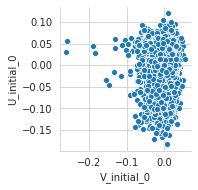

In [1547]:
first = True

last_score, (_, _, Us, Vs) , val_x_loss, val_y_loss = evaluate(val_loader, x_model, y_model, x_eval_step, y_eval_step, first=first)
draw_correlations(Us, Vs, True, labels=['U_initial', 'V_initial'])
training_first_score, (_, _, Us, Vs) , train_x_loss, train_y_loss = evaluate(train_loader, x_model, y_model, x_eval_step, y_eval_step, first=first)

In [1548]:
s = f'epoch: {-1}\tscore(correlation) {last_score:.3}\tX model loss {val_x_loss:.3}\tY model loss {val_y_loss:.3}'
print(s)

epoch: -1	score(correlation) 0.0666	X model loss 0.0113	Y model loss 0.0144


In [1549]:
scores = defaultdict(list)
losses = defaultdict(list)

max_score = -np.inf


# scores['validation'].append(last_score)
# # scores['training'].append(training_first_score)
# scores['epoch'].append(-1)

# losses['x_model_validation'].append(val_x_loss)
# losses['y_model_validation'].append(val_y_loss)
# losses['x_model_training'].append(train_x_loss)
# losses['y_model_training'].append(train_y_loss)
# losses['epoch'].append(-1)

for epoch in range(max_epochs):
  # train
  train_score, train_x_loss, train_y_loss = learn(train_loader, x_model, y_model, x_train_step, y_train_step, _max_samples=max_samples, first=first)
  if first:
    first = False
  # validate
  current_score, (Xs, Ys, Us, Vs), val_x_loss, val_y_loss = evaluate(val_loader, x_model, y_model, x_eval_step, y_eval_step)

  # log
  # scores['training'].append(train_score)
  losses['x_model_training'].append(train_x_loss)
  losses['y_model_training'].append(train_y_loss)
  
  scores['epoch'].append(epoch)
  losses['epoch'].append(epoch)
  scores['validation'].append(current_score)
  losses['x_model_validation'].append(val_x_loss)
  losses['y_model_validation'].append(val_y_loss)

  print(f'epoch: {epoch}\tscore(correlation) {last_score:.3}\tX model loss {val_x_loss:.3}\tY model loss {val_y_loss:.3}')
  
  if current_score > max_score:
    max_score = current_score
    save_model(x_model, 'x_model_best.pth')
    save_model(y_model, 'y_model_best.pth')
  last_score = current_score
  
  

epoch: 0	score(correlation) 0.0666	X model loss 1.71	Y model loss 1.53e+04
epoch: 1	score(correlation) -0.15	X model loss 1.75	Y model loss 8.23e+03
epoch: 2	score(correlation) -0.154	X model loss 1.79	Y model loss 1.19e+04
epoch: 3	score(correlation) -0.17	X model loss 1.81	Y model loss 8.44e+03
epoch: 4	score(correlation) -0.158	X model loss 1.87	Y model loss 1.24e+04
epoch: 5	score(correlation) -0.182	X model loss 1.82	Y model loss 8.09e+03
epoch: 6	score(correlation) -0.142	X model loss 1.83	Y model loss 1.38e+04
epoch: 7	score(correlation) -0.179	X model loss 1.84	Y model loss 1.24e+04
epoch: 8	score(correlation) -0.173	X model loss 1.77	Y model loss 1.37e+04
epoch: 9	score(correlation) -0.157	X model loss 1.69	Y model loss 9.42e+03


In [1550]:
x_model_best = load_model('x_model_best.pth')
y_model_best = load_model('y_model_best.pth')

In [1551]:
# re-evaluate
Us = x_model_best(X_test).detach().numpy()
Vs = y_model_best(Y_test).detach().numpy()

-0.11131361746519712	
U_final: mean -0.03940724581480026, std 0.7503248453140259
V_final: mean -35.22578811645508, std 90.29317474365234


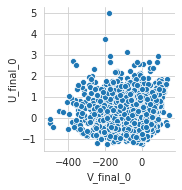

In [1552]:
draw_correlations(Us, Vs, True, labels=['U_final', 'V_final'])
print(f'U_final: mean {Us.mean(axis=0).item()}, std {Us.std(axis=0).item()}')
print(f'V_final: mean {Vs.mean(axis=0).item()}, std {Vs.std(axis=0).item()}')

Find linear CCA result for wanted dim

In [1553]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=1)
X_train_c, Y_train_c = cca.fit_transform(X_train, Y_train)
X_c, Y_c = cca.transform(Xs, Ys)
print(f'X_c: mean {X_c.mean(axis=0)}, std {X_c.std(axis=0)}')
print(f'Y_c: mean {Y_c.mean(axis=0)}, std {Y_c.std(axis=0)}')

# CCAtrain = draw_correlations(X_train_c, Y_train_c)
CCAtest = draw_correlations(X_c, Y_c, False)

X_c: mean [-0.02303729], std [1.03636589]
Y_c: mean [-12.42811169], std [0.63873849]
0.8927909439951558	


0.8927909439951558	


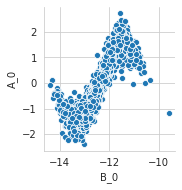

In [1554]:
CCAtest = draw_correlations(X_c, Y_c, True)

-0.8292817569287703	
0.07906060004669088	


[0.07906060004669088]

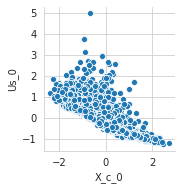

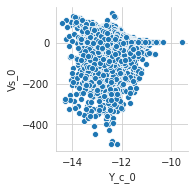

In [1555]:
draw_correlations(Us, X_c, True, labels=['Us', 'X_c'])
draw_correlations(Vs, Y_c, True, labels=['Vs', 'Y_c'])

0.001229941627788254	


0.817648317293053

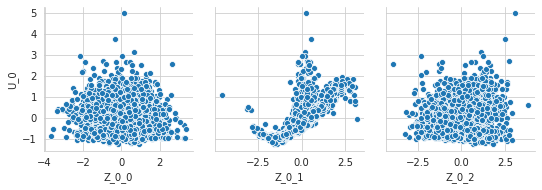

In [1556]:
draw_correlations(Us, Z_test, True, labels=['U', f'Z_{i}'])
cor = np.corrcoef(Us, Z_test, False)
mask = np.ones(cor.shape, dtype=bool)
np.fill_diagonal(mask, 0)
cor[mask].max()

In [1557]:
# scores['LinearCCA training'] = [max(CCAtrain)] * len(scores['epoch'])
scores['LinearCCA validation'] = [max(CCAtest)] * len(scores['epoch'])
scores['Maximum score'] = [max(draw_correlations(X_prior, Y_prior))] * len(scores['epoch'])
scores['Maximum Linear score'] = [max(draw_correlations(X_non_linear, Y_non_linear))] * len(scores['epoch'])

0.8007245648458264	0.9900756677139243	0.390311709124985	
0.0014105463566681895	0.8882965162796709	-0.012946599640894684	


In [1558]:
# len(scores['epoch'])

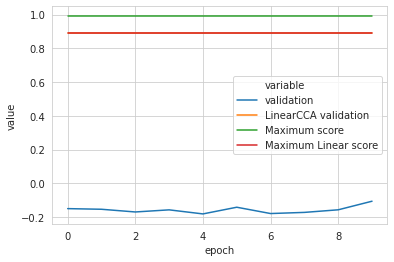

In [1559]:
scores_data = pd.DataFrame(scores)
df_scores = pd.melt(scores_data, 'epoch')
g = sns.lineplot('epoch', 'value', 'variable', data=df_scores)


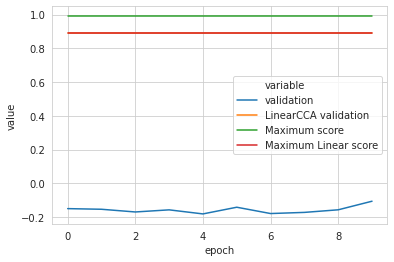

In [1560]:
df_scores = pd.melt(scores_data[scores_data.epoch != -1], 'epoch')
g = sns.lineplot('epoch', 'value', 'variable', data=df_scores)

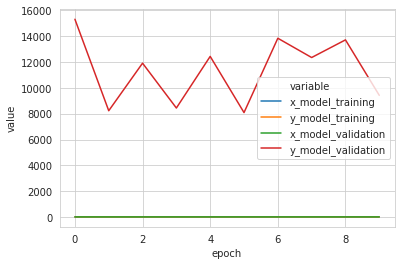

In [1561]:
losses_data = pd.DataFrame(losses)
df_losses = pd.melt(losses_data, 'epoch')
sns.lineplot('epoch', 'value', 'variable', data=df_losses)